In [3]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from pycocotools.coco import COCO

## Setting and config

In [4]:
root_dir = r"D:/Datasets/CocoAnotations"
images_dir = "images"
annotations_path = root_dir + "/instances_default.json"

coco_obj = COCO(annotations_path)

classes = {
    1: "Multicopter",
    2: "Wing",
    3: "Xwing",
}

colors = {
    1: "blue",
    2: "green",
    3: "red",
}

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


In [5]:
with open(annotations_path, 'r') as f:
    root = json.load(f)

print(root.keys())

dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])


## Basic High Level Information

In [6]:
n_images = len(root['images'])
n_boxes = len(root['annotations'])
n_classes = len(root['categories'])

# height, width
heights = [x['height'] for x in root['images']]
widths = [x['width'] for x in root['images']]

print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_classes)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

Number of images:  159530
Number of bounding boxes:  136836
Number of classes:  3
Max min avg height:  2058 1080 1203
Max min avg width:  2220 1080 1779


## Distribution of objects across images

In [7]:
from collections import Counter

img2nboxes = {}

for ann in root['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1
        
nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

counts = Counter(nboxes_list)

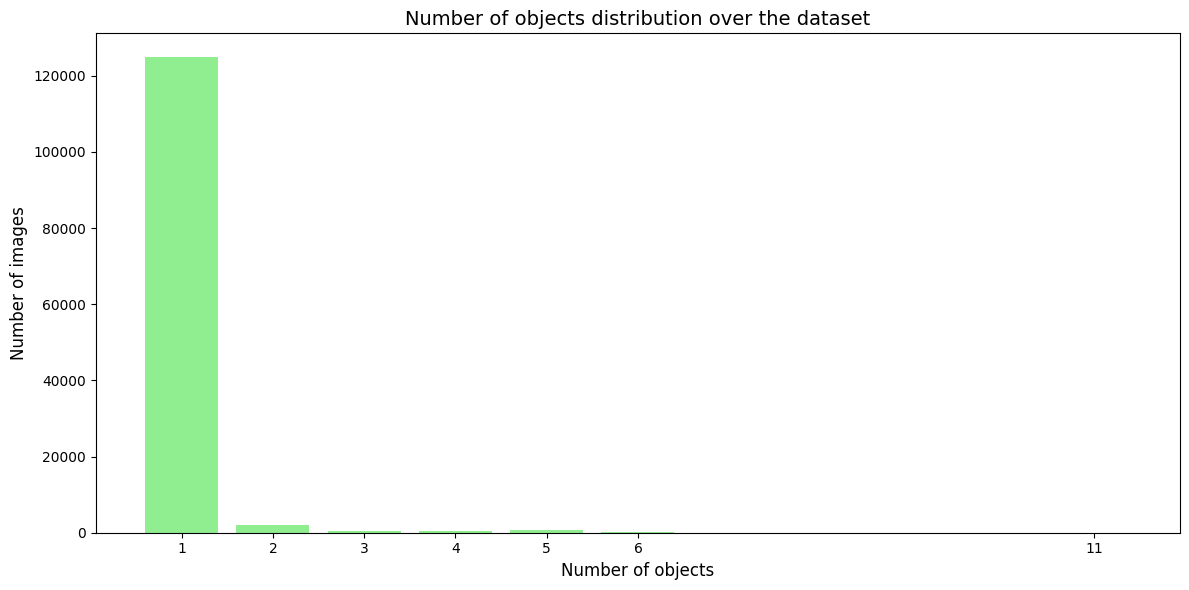

Number of images having at least one box:  128614
Min number of boxes per image:  1
Max number of boxes per image:  11
Avg number of boxes per image:  1

Number of images for each object count:
1 object(s): 124922 images
2 object(s): 1900 images
3 object(s): 368 images
4 object(s): 554 images
5 object(s): 656 images
6 object(s): 168 images
11 object(s): 46 images


In [8]:
# plot

graph_xind = sorted(counts.keys())
graph_yvals = [counts[x] for x in graph_xind]

plt.figure(figsize=(12, 6))
plt.bar(graph_xind, graph_yvals, width=0.8, color='lightgreen')
plt.xticks(graph_xind, fontsize=10)
plt.xlabel('Number of objects', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.title('Number of objects distribution over the dataset', fontsize=14)
plt.tight_layout()
plt.show()

print("Number of images having at least one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

print("\nNumber of images for each object count:")
for n_objects, n_images in sorted(counts.items()):
    print(f"{n_objects} object(s): {n_images} images")

## Class wise distribution of objects

In [9]:


class2nboxes = {}

for ann in root['annotations']:
    cat_id = ann['category_id']
    
    if cat_id in class2nboxes.keys():
        class2nboxes[cat_id] += 1
    else:
        class2nboxes[cat_id] = 1

sorted_c2nb = [(k,v) for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]
total_boxes = sum(class2nboxes.values())

top = min(len(sorted_c2nb),3)

print("Average Bounding Box Area per Class:")
for class_id, count in sorted_c2nb:
    class_name = classes.get(class_id, f"Unknown ({class_id})")
    percentage = (count / total_boxes) * 100
    print(f"Class '{class_name}' ({class_id}): {count} boxes ({percentage:.2f}%)")

Average Bounding Box Area per Class:
Class 'Wing' (2): 74823 boxes (54.68%)
Class 'Multicopter' (1): 47266 boxes (34.54%)
Class 'Xwing' (3): 14747 boxes (10.78%)


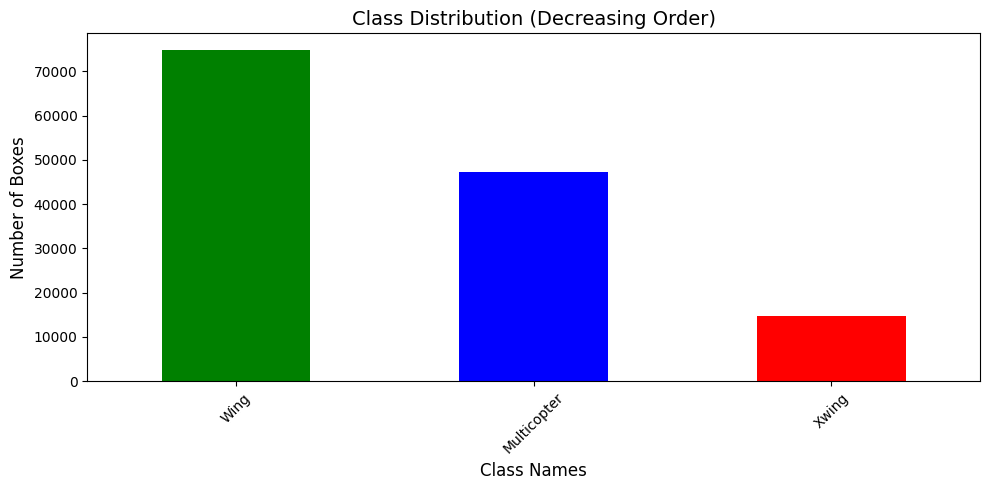

In [10]:
# plot 

y = [i[1] for i in sorted_c2nb]  
x = [classes[i[0]] for i in sorted_c2nb] 
bar_colors = [colors[i[0]] for i in sorted_c2nb]

plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(y)), y, width=0.5, tick_label=x, color=bar_colors)
plt.xlim(-0.5, len(y) - 0.5)
plt.xlabel('Class Names', fontsize=12)
plt.ylabel('Number of Boxes', fontsize=12)
plt.title('Class Distribution (Decreasing Order)', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


## Class wise bounding box area distribution

In [11]:
# key: class index,
# value: list of bounding box areas
bbox_areas = {} 

for ann in root['annotations']:
    area = ann['area']
    cat_id = ann['category_id']
    
    if area <= 0.0:
        continue
    
    if cat_id in bbox_areas.keys():
        bbox_areas[cat_id].append(area)
    else:
        bbox_areas[cat_id] = [area]


bbox_avg_areas = []

for cat in bbox_areas.keys():
    areas = bbox_areas[cat]
    avg_area = int(sum(areas)/len(areas))
    
    bbox_avg_areas.append((cat,avg_area))

bbox_avg_areas = sorted(bbox_avg_areas, key = lambda x: x[1])

<Figure size 1000x1000 with 0 Axes>

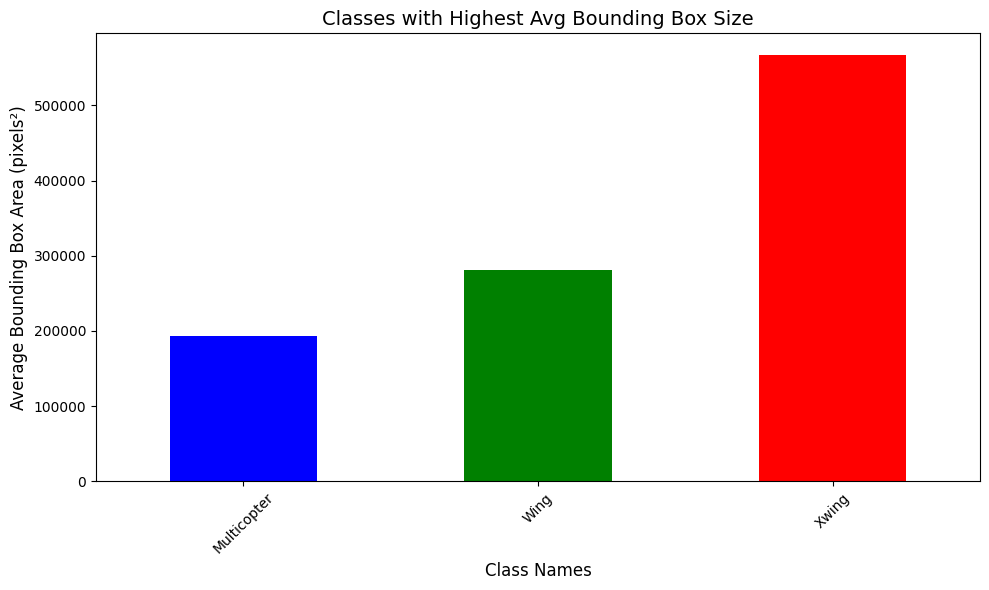

Average Bounding Box Area per Class:
Class 'Multicopter' (1): Avg bbox area = 193372 pixels²
Class 'Wing' (2): Avg bbox area = 281157 pixels²
Class 'Xwing' (3): Avg bbox area = 567641 pixels²


In [12]:
# plot
plt.figure(figsize=(10,10))

y = [item[1] for item in bbox_avg_areas]
x = [classes[item[0]] for item in bbox_avg_areas]
bar_colors = [colors[item[0]] for item in bbox_avg_areas]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(y)), y, width=0.5, tick_label=x, color=bar_colors)
plt.xlim(-0.5, len(y) - 0.5)
plt.xlabel('Class Names', fontsize=12)
plt.ylabel('Average Bounding Box Area (pixels²)', fontsize=12)
plt.title('Classes with Highest Avg Bounding Box Size', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


print("Average Bounding Box Area per Class:")
for cat_id, avg_area in bbox_avg_areas:
    class_name = classes.get(cat_id, f"Unknown ({cat_id})")
    print(f"Class '{class_name}' ({cat_id}): Avg bbox area = {avg_area} pixels²")

## Viewing random images

['Wing']


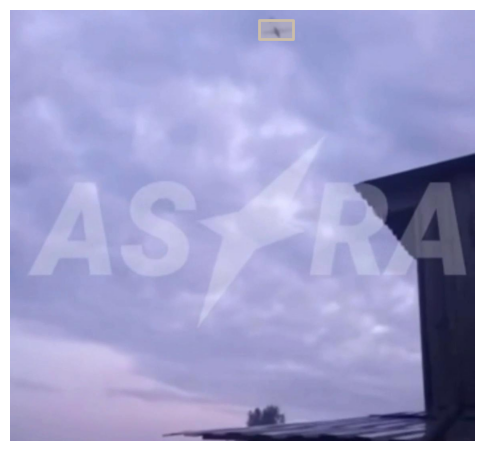

In [29]:
category_map = {x['id']: x['name'] for x in root['categories']}

# generate a random image
imgIds = [i['id'] for i in root['images']]
catIds = [i['id'] for i in root['categories']]
img = coco_obj.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
img_path= os.path.join(root_dir, images_dir, img['file_name'])
I = io.imread(img_path)

# plot annotations
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(I)
annIds = coco_obj.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_obj.loadAnns(annIds)

#  disable segmentation
for a in anns:
    if 'segmentation' in a.keys():
        a['segmentation'] = []
coco_obj.showAnns(anns, draw_bbox=True)
classes = [category_map[a['category_id']] for a in anns]
print(classes)